# Lab 3 - NOISE SPECTRUM DENSITY ESTIMATION AND WIENER FILTERING

### Petko Petkov

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import periodogram, welch
import IPython
import cv2

## PSDs of the three noise files and color classification

== ../data/noise1.wav ==
periodogram: slope - 0.00 - white
welch: slope - -0.00 - white


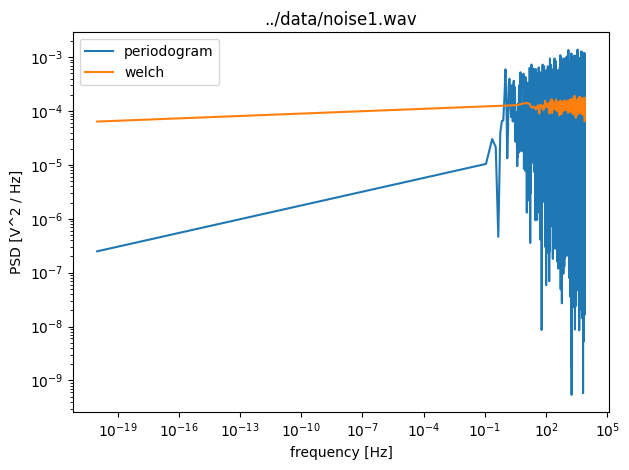

== ../data/noise2.wav ==
periodogram: slope - -0.70 - pink (1/f)
welch: slope - -0.68 - mixture/other (slope ≈ -0.68)


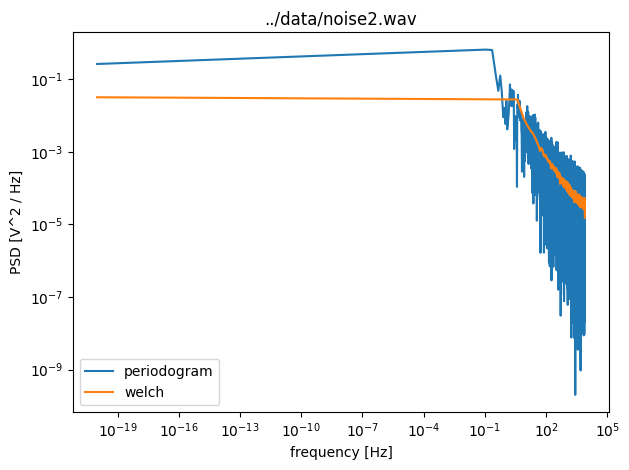

== ../data/noise3.wav ==
periodogram: slope - -0.31 - mixture/other (slope ≈ -0.31)
welch: slope - -0.29 - white


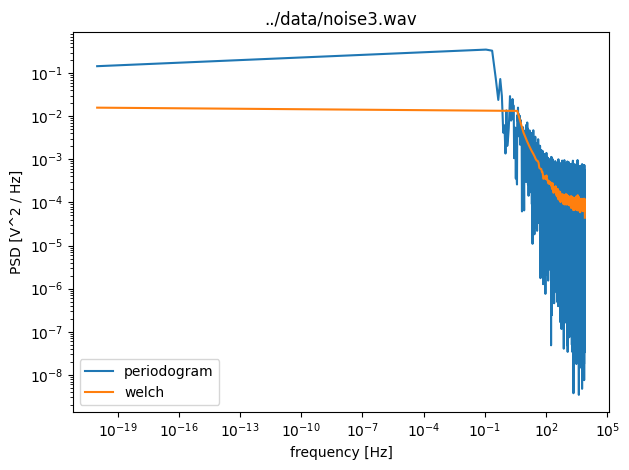

In [35]:
def load_wav_mono(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    if x.ndim == 2:  # stereo -> mono
        x = x.mean(axis=1)
    if x.dtype.kind in 'iu':
        maxv = np.iinfo(x.dtype).max
        x = x / maxv
    else:
        x = np.clip(x, -1, 1)
    return fs, x

def psd_periodogram(x, fs):
    f, Pxx = periodogram(x, fs=fs, window='hann', scaling='density', detrend=False)
    return f, Pxx

def psd_welch(x, fs, nperseg=4096, noverlap=None):
    if noverlap is None:
        noverlap = nperseg // 2
    f, Pxx = welch(x, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap,
                   detrend=False, scaling='density')
    return f, Pxx

def estimate_slope_color(f, Pxx):
    # ignore DC and highest 5% to avoid edge effects
    valid = (f > 0) & (f < 0.95*f.max())
    f = f[valid]; Pxx = Pxx[valid]
    x = np.log10(f)
    y = np.log10(Pxx + 1e-20)
    slope, intercept = np.polyfit(x, y, 1)
    # slope - 0 (white), - -1 (pink), - -2 (brown/red)
    if np.isfinite(slope):
        if abs(slope - 0) <= 0.3:
            color = "white"
        elif abs(slope + 1) <= 0.3:
            color = "pink (1/f)"
        elif abs(slope + 2) <= 0.4:
            color = "red/brown (1/f^2)"
        else:
            color = "mixture/other (slope ≈ %.2f)" % slope
    else:
        color = "undetermined"
    return slope, color

def analyze_noise(path):
    fs, x = load_wav_mono(path)
    f_p, P_p = psd_periodogram(x, fs)
    f_w, P_w = psd_welch(x, fs)
    slope_p, color_p = estimate_slope_color(f_p, P_p)
    slope_w, color_w = estimate_slope_color(f_w, P_w)

    print(f"== {path} ==")
    print(f"periodogram: slope - {slope_p:.2f} - {color_p}")
    print(f"welch: slope - {slope_w:.2f} - {color_w}")

    # Plots (log-log for visual check)
    plt.figure()
    plt.loglog(f_p+1e-20, P_p, label='periodogram')
    plt.loglog(f_w+1e-20, P_w, label='welch')
    plt.xlabel('frequency [Hz]'); plt.ylabel('PSD [V^2 / Hz]')
    plt.title(path)
    plt.legend(); plt.tight_layout()
    plt.show()

# Example for your three noises:
analyze_noise('../data/noise1.wav')
analyze_noise('../data/noise2.wav')
analyze_noise('../data/noise3.wav')


## Add gaussian noise at target SNRs to an image and an audio file

I'm applying the Additive white Gaussian noise (AWGN) model.

Original audio:

In [45]:
IPython.display.Audio('../data/music.wav')

Noisy audio:

In [36]:
from scipy.signal import stft, istft

def add_awgn_for_snr(x, snr_db):
    x = x.astype(np.float64)
    Psig = np.mean(x**2)
    sigma = np.sqrt(Psig / (10**(snr_db/10)))
    n = np.random.normal(0.0, sigma, size=x.shape)
    y = x + n
    return y, sigma**2

fs, clean = load_wav_mono('../data/music.wav')
for snr in [0, 5, 10, 15, 20]:
    y, noise_var = add_awgn_for_snr(clean, snr)
    wavfile.write(f'noisy_{snr}dB.wav', fs, np.int16(np.clip(y, -1, 1) * 32767))

In [37]:
IPython.display.Audio(f"noisy_0dB.wav")

In [38]:
IPython.display.Audio(f"noisy_5dB.wav")

In [39]:
IPython.display.Audio(f"noisy_10dB.wav")

In [40]:
IPython.display.Audio(f"noisy_15dB.wav")

In [41]:
IPython.display.Audio(f"noisy_20dB.wav")

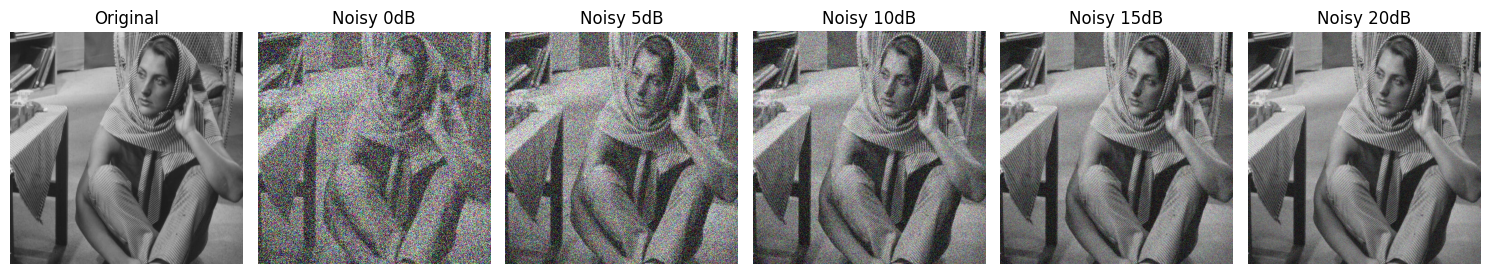

In [42]:
def to_float01(img):
    img = img.astype(np.float64)
    if img.max() > 1.0:
        img = img / 255.0
    return img

def add_awgn_image(img, snr_db):
    img = to_float01(img)
    Psig = np.mean(img**2)
    sigma = np.sqrt(Psig / (10**(snr_db/10)))
    noise = np.random.normal(0.0, sigma, size=img.shape)
    y = img + noise
    y = np.clip(y, 0.0, 1.0)
    return y, sigma**2

img = cv2.imread('../data/barbara.jpg')
for snr in [0, 5, 10, 15, 20]:
    y, noise_var = add_awgn_image(img, snr)
    cv2.imwrite(f'noisy_{snr}dB.jpg', (y*255).astype(np.uint8))

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')
for i, snr in enumerate([0, 5, 10, 15,
    20], start=1):
        noisy_img = cv2.imread(f'noisy_{snr}dB.jpg')
        axes[i].imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Noisy {snr}dB')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

## Denoise with a Wiener filter

In [43]:
def wiener_stft_audio(y, fs, noise_var, nperseg=1024, noverlap=512):
    f, t, Y = stft(y, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap)
    Pyy = np.abs(Y)**2
    Sxx_hat = np.maximum(Pyy - noise_var, 0.0)
    G = Sxx_hat / (Sxx_hat + noise_var + 1e-20)
    Xhat = G * Y
    _, xhat = istft(Xhat, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap)
    xhat = xhat[:len(y)] # trim to original length
    return xhat

y, noise_var = add_awgn_for_snr(clean, 10)
xhat = wiener_stft_audio(y, fs, noise_var)
wavfile.write('denoised_10dB.wav', fs, np.int16(np.clip(xhat, -1, 1)*32767))
IPython.display.Audio(f"denoised_10dB.wav")

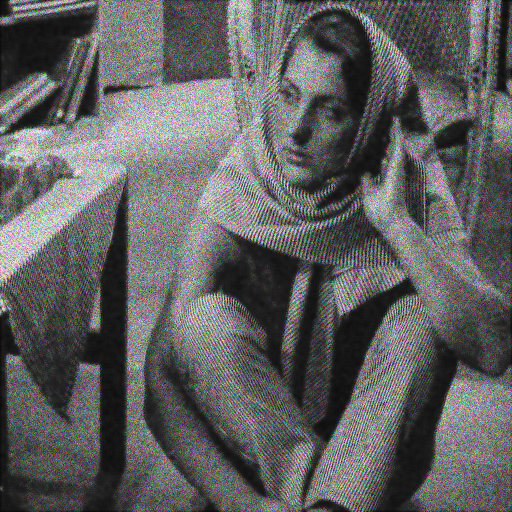

In [ ]:
from scipy.signal import wiener

def wiener_image(y, noise_var=None, mysize=5):
    if noise_var is None:
        return np.clip(wiener(y, mysize=mysize), 0, 1)
    else:
        return np.clip(wiener(y, mysize=mysize, noise=noise_var), 0, 1)

y, noise_var = add_awgn_image(img, 10)
den = wiener_image(y, noise_var=noise_var, mysize=5)
cv2.imwrite('denoised_10dB.png', (den*255).astype(np.uint8))
IPython.display.Image('denoised_10dB.png')